In [59]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, Bidirectional, MaxPooling1D, GRU, Reshape
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Desafio 3 - Pablo Segovia

## Consigna

- Entrenar un modelo de lenguaje basado en arquitectura recurrente, utilizando un corpus mayor al utilizado en clase.
- Explorar diferentes variantes de arquitecturas (GRU, LSTM, Bidireccionales, Cantidad de capas y neuronas, tamaño de contexto máximo)
- El objetivo principal sería lograr que durante el entrenamiento baje la perplejidad.
- Con el modelo que les haya resultado mejor, realizar algunas pruebas de generación de secuencias utilizando greedy search, beam search determinista y beam search estocástico (aquí pueden incluso variar la temperatura).

## Corpus elegido
- Se elige el corpus one_millon_headlines de Kaggle.
- https://www.kaggle.com/datasets/therohk/million-headlines/data

## Exploración del corpus

In [3]:
# Leemos el dataset
datafile = '/content/drive/MyDrive/Colab Notebooks/CEIA/04 - NLP/abcnews-date-text.csv'
raw_df = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

<ipython-input-3-4f603a5abe05>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_df = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)


In [4]:
# Vemos como está definido el .csv
raw_df.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [5]:
# Dejamos la columna que nos importa y calculamos la dimensión
df = raw_df['headline_text']
print(f"El numero de filas (headlines) que tiene el corpus es: {len(df)}")

El numero de filas (headlines) que tiene el corpus es: 1244184


In [6]:
# Por una cuestión de tiempo de procesamiento, tomamos un 1% del corpus
tenperc_text = len(df)/100
df = df.iloc[0:int(tenperc_text)]
print(f'La nueva longitud del texto es: {len(df)} filas')

La nueva longitud del texto es: 12441 filas


## Tamaño del contexto

In [7]:
# Cada verso lo guardamos en una lista
text = list(df)
print(f'Vemos los primero headlines de la lista: {text[:10]}')

Vemos los primero headlines de la lista: ['aba decides against community broadcasting licence', 'act fire witnesses must be aware of defamation', 'a g calls for infrastructure protection summit', 'air nz staff in aust strike for pay rise', 'air nz strike to affect australian travellers', 'ambitious olsson wins triple jump', 'antic delighted with record breaking barca', 'aussie qualifier stosur wastes four memphis match', 'aust addresses un security council over iraq', 'australia is locked into war timetable opp']


In [8]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

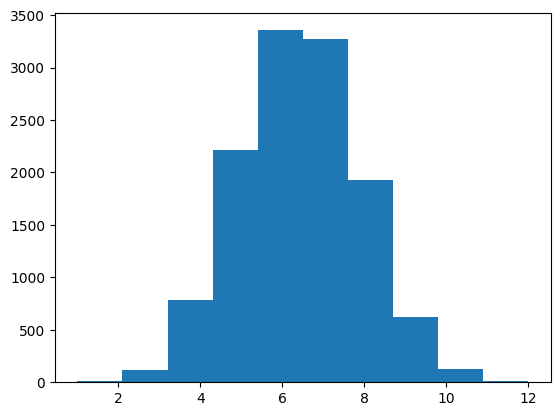

In [9]:
# Segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

# Calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

# Podemos ver su distribución
plt.hist(length_sentences,bins=10)
plt.show()

In [11]:
# Elegimos la mitad
max_context_size = 6

## Tokenizador

In [12]:
# Definimos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [13]:
# Vemos las primeras 10 frases tokenizadas
tokenized_sentences[:10]

[[2445, 3473, 39, 166, 3474, 1885],
 [126, 30, 1553, 298, 20, 3475, 4, 1418],
 [35, 1554, 92, 3, 2119, 945, 378],
 [139, 210, 362, 2, 64, 185, 3, 167, 214],
 [139, 210, 185, 1, 1022, 135, 2446],
 [6156, 6157, 111, 1555, 1694],
 [6158, 3476, 12, 177, 2120, 2888],
 [379, 2447, 6159, 6160, 158, 2889, 222],
 [64, 2448, 51, 93, 24, 7, 8],
 [72, 136, 4372, 33, 9, 6161, 481]]

## Organización y estructurda del dataset

In [14]:
# Usamos el train_test_split de skleant
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=17)

In [15]:
# Realizamos un separar las oraciones que tienen el tamaño más grande que el máximo tamaño de contexto
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [16]:
# Realizamos un data augmentation de estas oraciones
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [17]:
# Realizamos una concatenación de las secuencias y vemo su shape
train_seqs = np.concatenate(tok_sent_augm, axis=0)
print(f"Shape del dataset segmentado y aumentado: {train_seqs.shape}")

Shape del dataset segmentado y aumentado: (68475, 7)


In [18]:
# Generamos el X y el y
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [19]:
# Vemos cuantas palabras tiene el vocabulario
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

11248

## Callback de Perplexity

In [29]:
# Definimos el callbak para el cálculo de la Perplexity
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])
        self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

        self.info.append((count,count+len_seq))
        count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n log of mean perplexity: {np.log(np.mean(scores))} \n')

## Modelo 1: LSTM


In [28]:
# Elegimos un primer modelo
model_1 = Sequential()
model_1.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))
model_1.add(LSTM(64, return_sequences=True)) # Por ahí cambiar a LSTM 32
model_1.add(Dropout(0.2))
model_1.add(LSTM(64)) # por ahí también cambiar a 32 también
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(vocab_size+1, activation='softmax'))

# Compilamos y realizamos un summary
model_1.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam',
                 metrics=['accuracy'])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 6, 5)              56245     
                                                                 
 lstm_4 (LSTM)               (None, 6, 64)             17920     
                                                                 
 dropout_2 (Dropout)         (None, 6, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 11249)             371217    
                                                                 
Total params: 480486 (1.83 MB)
Trainable params: 48048

In [30]:
# Fiteamos el modelo
hist = model_1.fit(X, y, epochs=5,
                 callbacks=[PplCallback(tokenized_sentences_val)],
                 batch_size=32)

Epoch 1/5
2136/2140 [============================>.] - ETA: 0s - loss: 7.7876 - accuracy: 0.0489
 log of mean perplexity: 8.860346617794518 

2140/2140 [==============================] - 34s 14ms/step - loss: 7.7870 - accuracy: 0.0489
Epoch 2/5
2139/2140 [============================>.] - ETA: 0s - loss: 7.3944 - accuracy: 0.0489
 log of mean perplexity: 10.019685878068739 

2140/2140 [==============================] - 24s 11ms/step - loss: 7.3944 - accuracy: 0.0490
Epoch 3/5
2140/2140 [==============================] - ETA: 0s - loss: 7.2125 - accuracy: 0.0554
 log of mean perplexity: 10.917174385256844 

2140/2140 [==============================] - 27s 13ms/step - loss: 7.2125 - accuracy: 0.0554
Epoch 4/5
2137/2140 [============================>.] - ETA: 0s - loss: 6.9715 - accuracy: 0.0600
 log of mean perplexity: 12.438051468339719 

2140/2140 [==============================] - 24s 11ms/step - loss: 6.9716 - accuracy: 0.0599
Epoch 5/5
2139/2140 [============================>.] - ET

## Modelo 2: Conv1D y Bidirectional LSTM
- Al no poder disminuir la perplexity, vamos a usar un modelo más complejo.

In [35]:
# Segundo modelo
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas convolucionales:
model_2.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))

# Capas recurrentes bidireccionales (BRNN):
model_2.add(Bidirectional(LSTM(64, return_sequences=True)))
model_2.add(Dropout(0.2))

# Capa LSTM adicional:
model_2.add(Bidirectional(LSTM(64)))

# Capa densa con ReLU:
model_2.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax:
model_2.add(Dense(vocab_size+1, activation='softmax'))

# Compilamos
model_2.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 6, 5)              56245     
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 32)             512       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2, 32)             0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 2, 128)            49664     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 2, 128)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)              

In [36]:
# Entrenamos el segundo modelo
hist_2 = model_2.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/5
2140/2140 [==============================] - ETA: 0s - loss: 7.7629 - accuracy: 0.0488
 log of mean perplexity: 8.66168976516364 

2140/2140 [==============================] - 47s 18ms/step - loss: 7.7629 - accuracy: 0.0488
Epoch 2/5
2139/2140 [============================>.] - ETA: 0s - loss: 7.3659 - accuracy: 0.0491
 log of mean perplexity: 8.939096622679296 

2140/2140 [==============================] - 37s 17ms/step - loss: 7.3659 - accuracy: 0.0491
Epoch 3/5
2137/2140 [============================>.] - ETA: 0s - loss: 7.1890 - accuracy: 0.0527
 log of mean perplexity: 9.601253376294887 

2140/2140 [==============================] - 33s 15ms/step - loss: 7.1883 - accuracy: 0.0528
Epoch 4/5
2139/2140 [============================>.] - ETA: 0s - loss: 6.9780 - accuracy: 0.0584
 log of mean perplexity: 9.915274684658115 

2140/2140 [==============================] - 33s 15ms/step - loss: 6.9779 - accuracy: 0.0584
Epoch 5/5
2138/2140 [============================>.] - ETA: 0

## Modelo 3: Bidirectional LSTM stack
- Al no bajar la perplejidad, decidimos realizar un modelo más complejo.

In [38]:
# Realizamos un tercer modelo
model_3 = Sequential()
model_3.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas convolucionales:
model_3.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))

# Capas recurrentes bidireccionales (BRNN):
model_3.add(Bidirectional(LSTM(64, return_sequences=True)))
model_3.add(Dropout(0.2))
model_3.add(Bidirectional(LSTM(128)))

# Capa densa con ReLU:
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(vocab_size+1, activation='softmax'))

# Compilamos
model_3.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 6, 5)              56245     
                                                                 
 conv1d_4 (Conv1D)           (None, 4, 32)             512       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 2, 32)             0         
 g1D)                                                            
                                                                 
 bidirectional_4 (Bidirecti  (None, 2, 128)            49664     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 2, 128)            0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)              

In [40]:
# Entrenamos el tercer modelo
hist_3 = model_3.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/5
2139/2140 [============================>.] - ETA: 0s - loss: 7.7487 - accuracy: 0.0490
 log of mean perplexity: 8.423373927211196 

2140/2140 [==============================] - 38s 18ms/step - loss: 7.7490 - accuracy: 0.0490
Epoch 2/5
2140/2140 [==============================] - ETA: 0s - loss: 7.3417 - accuracy: 0.0501
 log of mean perplexity: 8.95627649663855 

2140/2140 [==============================] - 33s 15ms/step - loss: 7.3417 - accuracy: 0.0501
Epoch 3/5
2138/2140 [============================>.] - ETA: 0s - loss: 7.1182 - accuracy: 0.0538
 log of mean perplexity: 9.20982114105152 

2140/2140 [==============================] - 34s 16ms/step - loss: 7.1177 - accuracy: 0.0538
Epoch 4/5
2137/2140 [============================>.] - ETA: 0s - loss: 6.9115 - accuracy: 0.0582
 log of mean perplexity: 10.07518649847256 

2140/2140 [==============================] - 31s 15ms/step - loss: 6.9121 - accuracy: 0.0581
Epoch 5/5
2136/2140 [============================>.] - ETA: 0s

## Modelo 4: Conv1D stack, Bidirectional LSTM y GRU
- Añadimos mas complejidad a la arquitectura.

In [53]:
# Realizamos un cuarto modelo
model_4 = Sequential()
model_4.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas convolucionales:
model_4.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_4.add(MaxPooling1D(pool_size=2))
model_4.add(Dropout(0.2))
model_4.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_4.add(Dropout(0.2))

# Capas recurrentes bidireccionales (BRNN):
model_4.add(Bidirectional(LSTM(64, return_sequences=True)))
model_4.add(Bidirectional(GRU(128)))

# Capa densa con ReLU:
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(vocab_size+1, activation='softmax'))

# Compilamos
model_4.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model_4.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 6, 5)              56245     
                                                                 
 conv1d_19 (Conv1D)          (None, 4, 32)             512       
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 2, 32)             0         
 ng1D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_20 (Conv1D)          (None, 1, 64)             4160      
                                                                 
 dropout_13 (Dropout)        (None, 1, 64)             0         
                                                     

In [54]:
# Entrenamos el cuarto modelo
hist_4 = model_4.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/5
2140/2140 [==============================] - ETA: 0s - loss: 7.7635 - accuracy: 0.0489
 log of mean perplexity: 8.425652962234297 

2140/2140 [==============================] - 49s 19ms/step - loss: 7.7635 - accuracy: 0.0489
Epoch 2/5
2140/2140 [==============================] - ETA: 0s - loss: 7.3804 - accuracy: 0.0491
 log of mean perplexity: 9.178695753373011 

2140/2140 [==============================] - 38s 18ms/step - loss: 7.3804 - accuracy: 0.0491
Epoch 3/5
2138/2140 [============================>.] - ETA: 0s - loss: 7.2279 - accuracy: 0.0518
 log of mean perplexity: 9.245586859792926 

2140/2140 [==============================] - 36s 17ms/step - loss: 7.2279 - accuracy: 0.0518
Epoch 4/5
2139/2140 [============================>.] - ETA: 0s - loss: 7.0807 - accuracy: 0.0543
 log of mean perplexity: 9.672129547159498 

2140/2140 [==============================] - 32s 15ms/step - loss: 7.0808 - accuracy: 0.0543
Epoch 5/5
2140/2140 [==============================] - ETA: 

## Modelo 5: Aumento de LSTM con GRU
- Aumentamos la complejidad de la arquitectura.

In [65]:
# Realizamos un quitno modelo
model_5 = Sequential()
model_5.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas convolucionales:
model_5.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_5.add(MaxPooling1D(pool_size=2))
model_5.add(Dropout(0.2))
model_5.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_5.add(Dropout(0.2))

# Capas recurrentes bidireccionales (BRNN):
model_5.add(Bidirectional(LSTM(64, return_sequences=True)))
model_5.add(Bidirectional(GRU(128)))
model_5.add(Reshape((256, 1)))
model_5.add(Bidirectional(LSTM(32)))

# Capa densa con ReLU:
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(vocab_size+1, activation='softmax'))

# Compilamos
model_5.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model_5.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 6, 5)              56245     
                                                                 
 conv1d_35 (Conv1D)          (None, 4, 32)             512       
                                                                 
 max_pooling1d_23 (MaxPooli  (None, 2, 32)             0         
 ng1D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_36 (Conv1D)          (None, 1, 64)             4160      
                                                                 
 dropout_29 (Dropout)        (None, 1, 64)             0         
                                                     

In [66]:
# Entrenamos el quinto modelo
hist_5 = model_5.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/5
2140/2140 [==============================] - ETA: 0s - loss: 7.7744 - accuracy: 0.0486
 log of mean perplexity: 8.742335505984176 

2140/2140 [==============================] - 90s 36ms/step - loss: 7.7744 - accuracy: 0.0486
Epoch 2/5
2140/2140 [==============================] - ETA: 0s - loss: 7.3584 - accuracy: 0.0491
 log of mean perplexity: 8.855352119742001 

2140/2140 [==============================] - 74s 34ms/step - loss: 7.3584 - accuracy: 0.0491
Epoch 3/5
2140/2140 [==============================] - ETA: 0s - loss: 7.1943 - accuracy: 0.0519
 log of mean perplexity: 9.470258420491731 

2140/2140 [==============================] - 73s 34ms/step - loss: 7.1943 - accuracy: 0.0519
Epoch 4/5
2139/2140 [============================>.] - ETA: 0s - loss: 7.0639 - accuracy: 0.0532
 log of mean perplexity: 10.023485886482852 

2140/2140 [==============================] - 73s 34ms/step - loss: 7.0638 - accuracy: 0.0532
Epoch 5/5
2140/2140 [==============================] - ETA:

## Modelo 6: Aumento de neuronas
- Elegimos el model_4 que tuvo la mejor perplexity y probamos un cambio de numero de neuronas en búsqueda de bajar la perplexity.

In [69]:
# Realizamos un cuarto modelo
model_6 = Sequential()
model_6.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas convolucionales:
model_6.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_6.add(MaxPooling1D(pool_size=2))
model_6.add(Dropout(0.2))
model_6.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_6.add(Dropout(0.2))

# Capas recurrentes bidireccionales (BRNN):
model_6.add(Bidirectional(LSTM(128, return_sequences=True)))
model_6.add(Bidirectional(GRU(256)))

# Capa densa con ReLU:
model_6.add(Dense(128, activation='relu'))
model_6.add(Dense(vocab_size+1, activation='softmax'))

# Compilamos
model_6.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model_6.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 6, 5)              56245     
                                                                 
 conv1d_39 (Conv1D)          (None, 4, 64)             1024      
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 2, 64)             0         
 ng1D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 2, 64)             0         
                                                                 
 conv1d_40 (Conv1D)          (None, 1, 128)            16512     
                                                                 
 dropout_33 (Dropout)        (None, 1, 128)            0         
                                                     

In [70]:
# Entrenamos el sexto modelo
hist_6 = model_6.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/5
2140/2140 [==============================] - ETA: 0s - loss: 7.7595 - accuracy: 0.0486
 log of mean perplexity: 8.533316446277947 

2140/2140 [==============================] - 49s 19ms/step - loss: 7.7595 - accuracy: 0.0486
Epoch 2/5
2138/2140 [============================>.] - ETA: 0s - loss: 7.3418 - accuracy: 0.0504
 log of mean perplexity: 9.04059275900507 

2140/2140 [==============================] - 39s 18ms/step - loss: 7.3417 - accuracy: 0.0504
Epoch 3/5
2140/2140 [==============================] - ETA: 0s - loss: 7.1417 - accuracy: 0.0535
 log of mean perplexity: 9.471852932054372 

2140/2140 [==============================] - 34s 16ms/step - loss: 7.1417 - accuracy: 0.0535
Epoch 4/5
2139/2140 [============================>.] - ETA: 0s - loss: 6.9660 - accuracy: 0.0565
 log of mean perplexity: 9.958456520526207 

2140/2140 [==============================] - 35s 16ms/step - loss: 6.9661 - accuracy: 0.0565
Epoch 5/5
2139/2140 [============================>.] - ETA: 0

## Modelo 7: Cambio de size del contexto máximo
- Como no mejoró el valor de perplexidad, vamos a modificar el tamaño del contexto máximo.

In [71]:
# Elegimos el máximo valor de la distribución
max_context_size = 12

In [80]:
# Definimos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [81]:
# Realizamos un separar las oraciones que tienen el tamaño más grande que el máximo tamaño de contexto
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

# Realizamos un data augmentation de estas oraciones
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

# Realizamos una concatenación de las secuencias y vemo su shape
train_seqs = np.concatenate(tok_sent_augm, axis=0)
print(f"Shape del dataset segmentado y aumentado: {train_seqs.shape}")

# Generamos el X y el y
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

# Vemos cuantas palabras tiene el vocabulario
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
print(f'El tamaño del vocabulario es ahora: {vocab_size}')

Shape del dataset segmentado y aumentado: (54045, 13)
El tamaño del vocabulario es ahora: 23101


In [74]:
# Realizamos un séptimo modelo de la base del model_4
model_7 = Sequential()
model_7.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas convolucionales:
model_7.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_7.add(MaxPooling1D(pool_size=2))
model_7.add(Dropout(0.2))
model_7.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_7.add(Dropout(0.2))

# Capas recurrentes bidireccionales (BRNN):
model_7.add(Bidirectional(LSTM(64, return_sequences=True)))
model_7.add(Bidirectional(GRU(128)))

# Capa densa con ReLU:
model_7.add(Dense(64, activation='relu'))
model_7.add(Dense(vocab_size+1, activation='softmax'))

# Compilamos
model_7.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model_7.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 12, 5)             56245     
                                                                 
 conv1d_41 (Conv1D)          (None, 10, 32)            512       
                                                                 
 max_pooling1d_26 (MaxPooli  (None, 5, 32)             0         
 ng1D)                                                           
                                                                 
 dropout_34 (Dropout)        (None, 5, 32)             0         
                                                                 
 conv1d_42 (Conv1D)          (None, 4, 64)             4160      
                                                                 
 dropout_35 (Dropout)        (None, 4, 64)             0         
                                                     

In [75]:
# Entrenamos el séptimo modelo
hist_7 = model_7.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/5
1689/1689 [==============================] - ETA: 0s - loss: 7.9789 - accuracy: 0.0433
 log of mean perplexity: 8.495170524984351 

1689/1689 [==============================] - 46s 20ms/step - loss: 7.9789 - accuracy: 0.0433
Epoch 2/5
1689/1689 [==============================] - ETA: 0s - loss: 7.5617 - accuracy: 0.0437
 log of mean perplexity: 8.769002798477448 

1689/1689 [==============================] - 28s 17ms/step - loss: 7.5617 - accuracy: 0.0437
Epoch 3/5
1688/1689 [============================>.] - ETA: 0s - loss: 7.3880 - accuracy: 0.0478
 log of mean perplexity: 9.32348634777488 

1689/1689 [==============================] - 29s 17ms/step - loss: 7.3886 - accuracy: 0.0478
Epoch 4/5
1688/1689 [============================>.] - ETA: 0s - loss: 7.2078 - accuracy: 0.0510
 log of mean perplexity: 9.63043988931439 

1689/1689 [==============================] - 30s 18ms/step - loss: 7.2078 - accuracy: 0.0510
Epoch 5/5
1689/1689 [==============================] - ETA: 0s

## Modelo 8: Cambio del tamaño del corpus
- Como ninguno de estos 7 modelos mejoró, vamos a aumentar el tamaño del corpus siempre y cuando tengamos memoria suficiente para poder entrenar.

In [103]:
# Dejamos la columna que nos importa y calculamos la dimensión
df = raw_df['headline_text']
print(f"El numero de filas (headlines) que tiene el corpus es: {len(df)}")

# Por una cuestión de tiempo de procesamiento, tomamos una parte del corpus
tenperc_text = len(df)/5
df = df.iloc[0:int(tenperc_text)]
print(f'La nueva longitud del texto es: {len(df)} filas')

El numero de filas (headlines) que tiene el corpus es: 1244184
La nueva longitud del texto es: 248836 filas


La longitud del texto es: 248836
Vemos los primero headlines de la lista: ['aba decides against community broadcasting licence', 'act fire witnesses must be aware of defamation', 'a g calls for infrastructure protection summit', 'air nz staff in aust strike for pay rise', 'air nz strike to affect australian travellers', 'ambitious olsson wins triple jump', 'antic delighted with record breaking barca', 'aussie qualifier stosur wastes four memphis match', 'aust addresses un security council over iraq', 'australia is locked into war timetable opp']


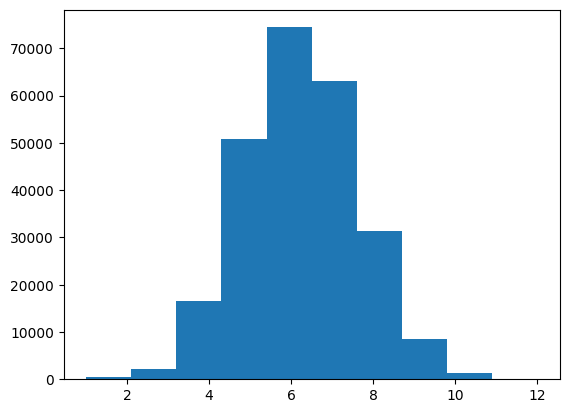

In [104]:
# Cada verso lo guardamos en una lista
text = list(df)
print(f'La longitud del texto es: {len(text)}')
print(f'Vemos los primero headlines de la lista: {text[:10]}')

# Segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

# Calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

# Podemos ver su distribución
plt.hist(length_sentences,bins=10)
plt.show()

In [105]:
# Elegimos el contexto máximo como 12
max_context_size = 12

In [106]:
# Definimos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [107]:
# Como se mantiene el contexto máximo podemos seguir de la siguiente manera
# Realizamos un separar las oraciones que tienen el tamaño más grande que el máximo tamaño de contexto
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

# Realizamos un data augmentation de estas oraciones
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

# Realizamos una concatenación de las secuencias y vemo su shape
train_seqs = np.concatenate(tok_sent_augm, axis=0)
print(f"Shape del dataset segmentado y aumentado: {train_seqs.shape}")

# Generamos el X y el y
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

# Vemos cuantas palabras tiene el vocabulario
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
print(f'El tamaño del vocabulario es ahora: {vocab_size}')

Shape del dataset segmentado y aumentado: (54045, 13)
El tamaño del vocabulario es ahora: 38997


In [108]:
# Realizamos un séptimo modelo de la base del model_4
model_8 = Sequential()
model_8.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas convolucionales:
model_8.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_8.add(MaxPooling1D(pool_size=2))
model_8.add(Dropout(0.2))
model_8.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_8.add(Dropout(0.2))

# Capas recurrentes bidireccionales (BRNN):
model_8.add(Bidirectional(LSTM(64, return_sequences=True)))
model_8.add(Bidirectional(GRU(128)))

# Capa densa con ReLU:
model_8.add(Dense(64, activation='relu'))
model_8.add(Dense(vocab_size+1, activation='softmax'))

# Compilamos
model_8.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model_8.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 12, 5)             194990    
                                                                 
 conv1d_49 (Conv1D)          (None, 10, 32)            512       
                                                                 
 max_pooling1d_30 (MaxPooli  (None, 5, 32)             0         
 ng1D)                                                           
                                                                 
 dropout_42 (Dropout)        (None, 5, 32)             0         
                                                                 
 conv1d_50 (Conv1D)          (None, 4, 64)             4160      
                                                                 
 dropout_43 (Dropout)        (None, 4, 64)             0         
                                                     

In [109]:
# Entrenamos el octavo modelo
hist_8 = model_8.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/5
1689/1689 [==============================] - ETA: 0s - loss: 8.2396 - accuracy: 0.0419
 log of mean perplexity: 8.685116231663697 

1689/1689 [==============================] - 59s 30ms/step - loss: 8.2396 - accuracy: 0.0419
Epoch 2/5
1689/1689 [==============================] - ETA: 0s - loss: 7.6159 - accuracy: 0.0434
 log of mean perplexity: 9.461838942380119 

1689/1689 [==============================] - 39s 23ms/step - loss: 7.6159 - accuracy: 0.0434
Epoch 3/5
1687/1689 [============================>.] - ETA: 0s - loss: 7.4684 - accuracy: 0.0430
 log of mean perplexity: 9.600930592003133 

1689/1689 [==============================] - 39s 23ms/step - loss: 7.4685 - accuracy: 0.0430
Epoch 4/5
1689/1689 [==============================] - ETA: 0s - loss: 7.3347 - accuracy: 0.0461
 log of mean perplexity: 9.713339085253834 

1689/1689 [==============================] - 43s 26ms/step - loss: 7.3347 - accuracy: 0.0461
Epoch 5/5
1687/1689 [============================>.] - ETA: 

- No se pudo mejorar la perplexity pero vamos a utilzar el mejor modelo, de valor más bajo para predecir.

## Predicción de la útlima palabra


In [110]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.7 MB/s 

In [111]:

import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2a38553a636d58be52.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2a38553a636d58be52.gradio.live


## Generación de secuencias

In [112]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [123]:
# Elegimos el primer texto
input_text='fire witnesses must'
generate_seq(model_7, tok, input_text, max_length=max_context_size, n_words=2)

1/1 [==============================] - 0s 82ms/step


'fire witnesses must to as'

In [124]:
# Probamos con un nuevo input
input_text='infrastructure protection summit'
generate_seq(model_7, tok, input_text, max_length=max_context_size, n_words=2)

1/1 [==============================] - 0s 28ms/step


'infrastructure protection summit to govt'

## Beam search

In [125]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [126]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [127]:
# predicción con beam search
salidas = beam_search(model_7,num_beams=10,num_words=6,input="fire witnesses must")

1/1 [==============================] - 0s 21ms/step


In [128]:
# veamos las salidas
decode(salidas[0])

['fire witnesses must tipped of govt still for cuts']

In [129]:
# predicción con beam search
salidas = beam_search(model_7,num_beams=10,num_words=6,input="infraestructure protection summit")

1/1 [==============================] - 0s 21ms/step


In [130]:
# veamos las salidas
decode(salidas[0])

['protection summit to medical revamp in from sun']

## Conclusión

- Se probaron en total 8 modelos modificando:
1. Arquitecturas.
2. Tipos de capas.
3. Aumento de neuronas.
4. Cambio de size del contexto máximo.
5. Cambio de tamaño del corpus.
- Si bien no se puedo llegar a mejorar la perplexity, tenemos una buena generación de texto.
